Event 21:
  Muon charges: Q_neg = -1, Q_pos = 1
  Muon (neg) 4-vector (lab): px=30.11, py=-16.40, pz=-39.69, E=52.45
  Muon (pos) 4-vector (lab): px=-46.15, py=29.41, pz=-24.41, E=59.92
  Z boson 4-vector: px=-16.04, py=13.01, pz=-64.09, E=112.37
  Boost vector (beta): x=-0.1428, y=0.1158, z=-0.5704
  Muon (neg) 4-vector (Z rest frame): px=37.83, py=-22.66, pz=-8.82, E=44.98
  cos(theta*): -0.1962
---------------------------------------------------
Event 46:
  Muon charges: Q_neg = -1, Q_pos = 1
  Muon (neg) 4-vector (lab): px=7.47, py=-30.71, pz=-149.67, E=152.97
  Muon (pos) 4-vector (lab): px=-9.29, py=28.75, pz=-14.67, E=33.58
  Z boson 4-vector: px=-1.82, py=-1.96, pz=-164.34, E=186.56
  Boost vector (beta): x=-0.0098, y=-0.0105, z=-0.8809
  Muon (neg) 4-vector (Z rest frame): px=8.77, py=-29.30, pz=-31.80, E=44.12
  cos(theta*): -0.7207
---------------------------------------------------
Event 78:
  Muon charges: Q_neg = -1, Q_pos = 1
  Muon (neg) 4-vector (lab): px=-34.63, py=12

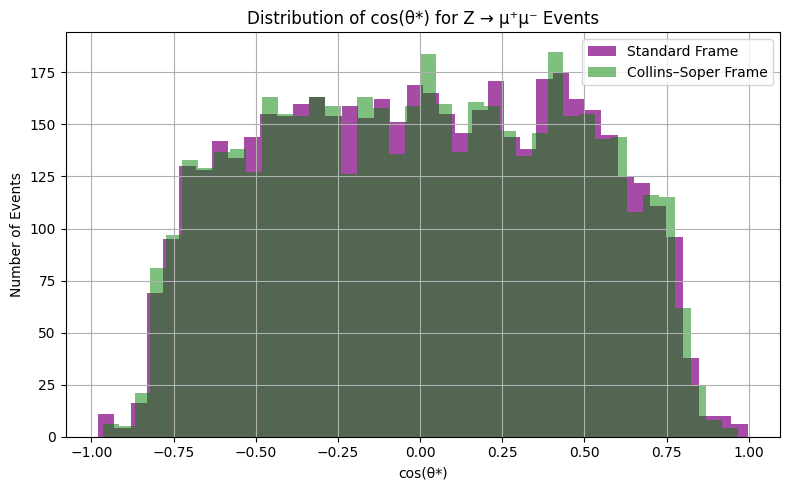

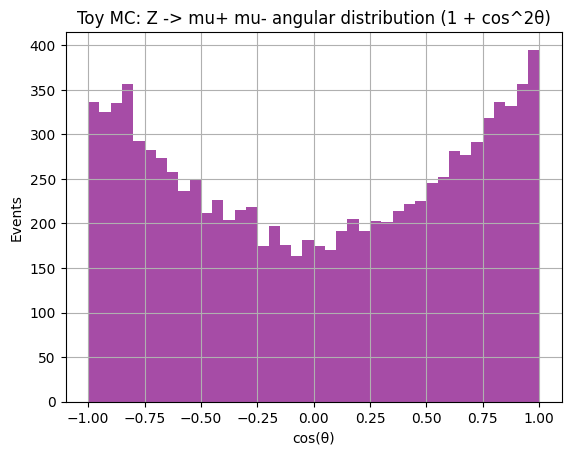

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vector

# --- 1. Load and Filter Data ---
data = pd.read_csv('/Users/xDAyN/Desktop/cs project/School Project/Dimuon_DoubleMu.csv')

# Apply Z Boson Selection Criteria
z_selection = (
    (data['type1'] == 'G') &  # Both muons are global
    (data['type2'] == 'G') &
    (data['Q1'] * data['Q2'] < 0) &  # Opposite charges
    (data['pt1'] > 25) &  # Transverse momentum cut
    (data['pt2'] > 25) &
    (np.abs(data['eta1']) < 2.4) &  # Pseudorapidity cut
    (np.abs(data['eta2']) < 2.4)
)
data = data[z_selection].copy()

# --- 2. Create 4-Vectors for Muons ---
v1_list = vector.array({
    "px": data["px1"].values,
    "py": data["py1"].values,
    "pz": data["pz1"].values,
    "E":  data["E1"].values
})
v2_list = vector.array({
    "px": data["px2"].values,
    "py": data["py2"].values,
    "pz": data["pz2"].values,
    "E":  data["E2"].values
})

# --- 3 & 4. Calculate Z boson 4-momentum, Identify Muon Charge and Boost ---
mu_minus = []
Z_list = []
mu_boosted = []
cos_theta_star = []

for i, row in data.iterrows():
    # Determine which muon is negatively charged
    if row['Q1'] < 0:
        mu = vector.obj(px=row['px1'], py=row['py1'], pz=row['pz1'], E=row['E1'])
        mu_pos = vector.obj(px=row['px2'], py=row['py2'], pz=row['pz2'], E=row['E2'])
        q_neg = row['Q1']
        q_pos = row['Q2']
    else:
        mu = vector.obj(px=row['px2'], py=row['py2'], pz=row['pz2'], E=row['E2'])
        mu_pos = vector.obj(px=row['px1'], py=row['py1'], pz=row['pz1'], E=row['E1'])
        q_neg = row['Q2']
        q_pos = row['Q1']

    mu_minus.append(mu)

    # Z boson 4-momentum
    Z = vector.obj(px=row['px1'] + row['px2'],
                   py=row['py1'] + row['py2'],
                   pz=row['pz1'] + row['pz2'],
                   E=row['E1'] + row['E2'])
    Z_list.append(Z)

    # Boost vector beta = Z velocity vector
    beta = vector.obj(x=Z.px / Z.E, y=Z.py / Z.E, z=Z.pz / Z.E)

    # Boost muon into Z rest frame
    mu_rest = mu.boost(-beta)
    mu_boosted.append(mu_rest)

    # Calculate cos(theta*)
    cos_theta = mu_rest.z / np.sqrt(mu_rest.x**2 + mu_rest.y**2 + mu_rest.z**2)
    cos_theta_star.append(cos_theta)

    # Print detailed info for this event
    print(f"Event {i}:")
    print(f"  Muon charges: Q_neg = {q_neg}, Q_pos = {q_pos}")
    print(f"  Muon (neg) 4-vector (lab): px={mu.px:.2f}, py={mu.py:.2f}, pz={mu.pz:.2f}, E={mu.E:.2f}")
    print(f"  Muon (pos) 4-vector (lab): px={mu_pos.px:.2f}, py={mu_pos.py:.2f}, pz={mu_pos.pz:.2f}, E={mu_pos.E:.2f}")
    print(f"  Z boson 4-vector: px={Z.px:.2f}, py={Z.py:.2f}, pz={Z.pz:.2f}, E={Z.E:.2f}")
    print(f"  Boost vector (beta): x={beta.x:.4f}, y={beta.y:.4f}, z={beta.z:.4f}")
    print(f"  Muon (neg) 4-vector (Z rest frame): px={mu_rest.px:.2f}, py={mu_rest.py:.2f}, pz={mu_rest.pz:.2f}, E={mu_rest.E:.2f}")
    print(f"  cos(theta*): {cos_theta:.4f}")
    print("---------------------------------------------------")

# --- Collins–Soper frame calculation (moved outside main loop) ---
cos_theta_star_CS = []

pA_lab = vector.obj(px=0, py=0, pz=1, E=1)
pB_lab = vector.obj(px=0, py=0, pz=-1, E=1)

for i, (mu, Z) in enumerate(zip(mu_minus, Z_list)):
    beta = vector.obj(x=Z.px / Z.E, y=Z.py / Z.E, z=Z.pz / Z.E)

    mu_rest = mu.boost(-beta)
    pA_rest = pA_lab.boost(-beta)
    pB_rest = pB_lab.boost(-beta)

    pA_vec = np.array([pA_rest.px, pA_rest.py, pA_rest.pz])
    pB_vec = np.array([pB_rest.px, pB_rest.py, pB_rest.pz])
    mu_vec = np.array([mu_rest.px, mu_rest.py, mu_rest.pz])

    z_CS_vec = pA_vec - pB_vec
    z_CS_unit = z_CS_vec / np.linalg.norm(z_CS_vec)

    cos_theta_CS = np.dot(mu_vec, z_CS_unit) / np.linalg.norm(mu_vec)
    cos_theta_star_CS.append(cos_theta_CS)

    if i % 20000 == 0:
        print(f"Event {i}: cos(theta*) Collins–Soper = {cos_theta_CS:.4f}")

# --- 7. Plot Distribution ---
plt.figure(figsize=(8, 5))
plt.hist(cos_theta_star, bins=40, color='purple', alpha=0.7, label='Standard Frame')
plt.hist(cos_theta_star_CS, bins=40, color='green', alpha=0.5, label='Collins–Soper Frame')
plt.title('Distribution of cos(θ*) for Z → μ⁺μ⁻ Events')
plt.xlabel('cos(θ*)')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

N = 10000
# Generate cos(theta) with distribution ~ 1 + cos^2(theta)
# Using rejection sampling:

def sample_cos_theta(N):
    samples = []
    while len(samples) < N:
        x = np.random.uniform(-1,1)
        y = np.random.uniform(0,2)
        if y < 1 + x**2:
            samples.append(x)
    return np.array(samples)

cos_theta = sample_cos_theta(N)

plt.hist(cos_theta, bins=40, color='purple', alpha=0.7)
plt.title('Practice MC: Z -> mu+ mu- angular distribution (1 + cos^2θ)')
plt.xlabel('cos(θ)')
plt.ylabel('Events')
plt.grid(True)
plt.show()

